In [74]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne

def plot_decision_boundary(pred_func, X, y):
    #from https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    yy = yy.astype('float32')
    xx = xx.astype('float32')
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

    

# Neural networks 101
In this notebook you will implement a simple neural network in Lasagne utilizing the automatic differentiation engine of Theano. We assume that you are already familiar with backpropagation (if not please cf. [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/) or [Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html).
We'll not spend much time on how Theano works, but you can go through [this short tutorial](http://nbviewer.jupyter.org/github/craffel/theano-tutorial/blob/master/Theano%20Tutorial.ipynb) if you are interested).

Additionally, for the ambitious people we have previously made an assignment where you will implement both the forward and backpropagation in a neural network by hand, https://github.com/DTU-deeplearning/day1-NN/blob/master/exercises_1.ipynb. By following this you will get a thorough understanding of the deep learning basics.

In this exercise we'll start by defining a logistic regression model in Lasagne/Theano. Some details of Theano can be a bit confusing. For now you should pay most attention to the high-level network construction in Lasagne. We'll initially start with a simple 2-D and 2-class classification problem where the class decision boundary can be visualized. Initially we show that logistic regression can only separate classes linearly. Adding a non-linear hidden layer to the algorithm permits nonlinear class separation. If time permits we'll continue on to implement a fully connected neural network to classify the (in)famous MNIST dataset consisting of images of hand written digits. 


# Problem 
We'll initally demonstrate that MLPs can classify non-linear problems whereas simple logistic regression cannot. For ease of visualization and computational speed we'll initially experiment on the simple 2D half-moon dataset.

Shape of the input matrix dim(300 x 2).
Shape of the target matrix dim(300).


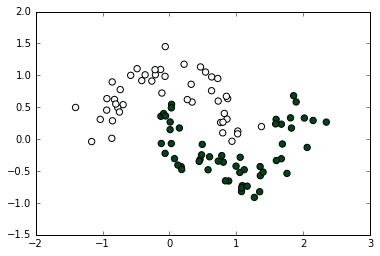

In [75]:
# Generate a dataset and plot it
np.random.seed(0)
num_samples = 300

X, y = sklearn.datasets.make_moons(num_samples, noise=0.20)

X_tr = X[:100].astype('float32')
X_val = X[100:200].astype('float32')
X_te = X[200:].astype('float32')

y_tr = y[:100].astype('int32')
y_val = y[100:200].astype('int32')
y_te = y[200:].astype('int32')

plt.scatter(X_tr[:,0], X_tr[:,1], s=40, c=y_tr, cmap=plt.cm.BuGn)

print("Shape of the input matrix dim(%i x %i)." % X.shape)
print("Shape of the target matrix dim(%i)." % y.shape)

num_features = X_tr.shape[-1]

# From Logistic Regression to "Deep Learning" in Lasagne
The code implements logistic regression in Lasagne. In section __Assignments Half Moon__ you are asked to modify the code into a neural network. 

The building blocks of lasagne are the layers. To get started, the most frequently used layers are the DenseLayer and the InputLayer. 

The [InputLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/input.html) is a "special" layer that lets you input data to the network. The InputLayer is initialized with a tuple specifying the shape of the input data. Note that it is common to provide ``None`` for the first dimension which allows you to vary the batch size at runtime. 

The [DenseLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/dense.html) implements the computation: 

$$y = nonlinearity(xW + b)$$

where $x$ is the layer input, $y$ is the layer output and $\{W, b\}$ are the layer parameters. The DenseLayer is initialized with a pointer to the previous layer, the desired number of units in the layer and the nonlinearity. 
x has shape ```[batchsize, num_features]```. From this we can infer the size of ```W``` as ```[num_features, num_units]``` and b as ```[num_units]```. y is then ```[batch_size, num_units]```.


A layer in Lasagne does the following:
1. Given the shape of the input $x$ and the number of units in the layer, Lasagne infers the shapes of $W$ and $b$ and keep track of the layer parameters.
2. Computes $y = nonlinearity(xW + b)$

In [120]:
from lasagne.updates import sgd # stochastic gradient descent optimization algorithm.
from lasagne.nonlinearities import leaky_rectify, softmax, tanh
from lasagne.layers import InputLayer, DenseLayer


#MODEL SPECIFICATION
l_in = InputLayer(shape=(None, num_features))
#INSERT HIDDEN LAYER HERE
#l = DenseLayer(incoming=l,.....
l_out = DenseLayer(incoming=l_in, num_units=2, nonlinearity=softmax, name='outputlayer') 
#We use two output units since we have two classes. The softmax function ensures that the the class probabilities sum to 1.

After we have built the network we can use the helper functions of lasagne to 

1. Build the computational graph: __[lasagne.layers.get_output](http://lasagne.readthedocs.io/en/latest/modules/layers/helper.html#lasagne.layers.get_output)__ . The ``deterministic`` flag tells lasagne if we are in training mode or evaluation mode. When you build more complicated networks this is very important to remember! (Two important layers that behave differently in training mode and evaluation mode are the [DropoutLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html#lasagne.layers.DropoutLayer) and the [BatchNormalizationLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/normalization.html?highlight=batchnorm#lasagne.layers.BatchNormLayer)). Building the computational graph gives us the forward-pass of the network.  
2. Collect the network parameters: __[lasagne.layers.get_all_params](http://lasagne.readthedocs.io/en/latest/modules/layers/helper.html#lasagne.layers.get_all_params)__ (Note the trainable flag which will only return parameters that are trainable. You'll get errors if your are using batchnorm and you forget this)

Note that all the helper functions are called with the output layer or a list of output layers if you have multiple output layers. 

In [121]:
sym_x = T.matrix('X') # a symbolic variable taking on the value of an input batch.
sym_t = T.ivector('target') # a symbolic variable taking on the value of the target batch.

# Get network output
train_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=True)

# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

# print shapes of all the parameters in the network.
for p in all_params:
    print(p, p.get_value().shape)

outputlayer.W (2, 2)
outputlayer.b (2,)


``train_out`` will be a symbolic variable representing the network output. Using ``train_out`` we  can define the [crossentropy error](http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.categorical_crossentropy) used for training the network.
We ```mean``` over all the samples in the mini-batch.


In [122]:
cost_train = T.nnet.categorical_crossentropy(train_out, sym_t).mean()
cost_eval = T.nnet.categorical_crossentropy(eval_out, sym_t).mean()

When we train a neural network we update the parameters in direction of the negative gradient w.r.t the cost.
We can use ``T.grad`` to get the gradients for all parameters in the network w.r.t ``cost_train``.
Imagine that ```cost_train``` is a function and we want to go downhill. We go downhill by changing the value of the parameters in direction of the negative gradient. 

Finally we can use __[lasagne.updates.sgd](http://lasagne.readthedocs.io/en/latest/modules/updates.html#lasagne.updates.sgd)__ to calculate the stochastic gradient descent (SGD) update rule for each parameter in the network. ``updates`` is a dictionary of the parameter update rules.

Here's a small animation of [different optimizers doing](http://lasagne.readthedocs.io/en/latest/modules/updates.html) gradient descent: http://imgur.com/a/Hqolp . E.g why saddle points might be difficult.

In [123]:
# Let Theano do its magic and get all the gradients we need for training. Essentially T.grad does backprop i.e. get the 
# gradient of cost_train w.r.t. the parameters.
all_grads = T.grad(cost_train, all_params)

# Set the update function for parameters 
# you might want to experiment with more advanded update schemes like rmsprob, adadelta etc.
updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=1.0)

The final step is to compile Theano functions for the network. For theano functions we need to specify which inputs the function should take. For our network that is ``sym_x``: the input data and ``sym_t``: the targets. Secondly we need to specify which outputs we want the network to return. In our case that is the cross-entropy cost and the network output.

When we compile ``f_train`` we additionally give the update dictionary as input. This tells Theano to update the network parameters with the update rules everytime we call ``f_train``. 

In [124]:
f_eval = theano.function(inputs=[sym_x, sym_t],
                         outputs=[cost_eval, eval_out])

f_train = theano.function(inputs=[sym_x, sym_t],
                          outputs=[cost_train, eval_out],
                          updates=updates)

#now you have three functions. 
# f_train(X,y) -> cost, y_pred which will update the parameters using backprop each time you call it, only use this on the training data!
# f_test(X,y) -> cost, y_pred which only calculates the forward pass

#This us just a helper function for plotting the decision boundaries between the two classes
f_pred = theano.function(inputs=[sym_x],
                         outputs=eval_out)

Epoch 0, Train Cost: 0.424	Val Cost: 0.416
Epoch 100, Train Cost: 0.303	Val Cost: 0.332
Epoch 200, Train Cost: 0.302	Val Cost: 0.333
Epoch 300, Train Cost: 0.302	Val Cost: 0.334
Epoch 400, Train Cost: 0.302	Val Cost: 0.334
Epoch 500, Train Cost: 0.302	Val Cost: 0.334
Epoch 600, Train Cost: 0.302	Val Cost: 0.334
Epoch 700, Train Cost: 0.302	Val Cost: 0.334
Epoch 800, Train Cost: 0.302	Val Cost: 0.334
Epoch 900, Train Cost: 0.302	Val Cost: 0.334

Test Cost: 0.270


(<matplotlib.text.Text at 0x7f432f389f60>,
 <matplotlib.text.Text at 0x7f432f397390>)

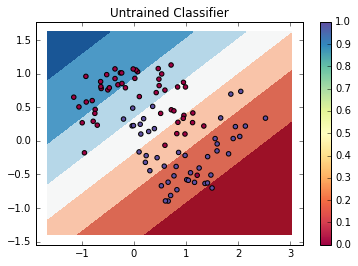

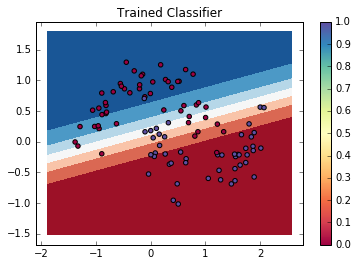

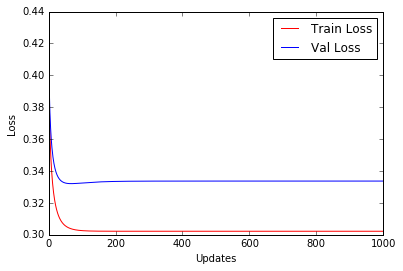

In [125]:
# Training loop
plot_decision_boundary(lambda x: f_pred(x), X_val,y_val)
plt.title("Untrained Classifier")
plt.colorbar()

num_epochs = 1000

train_cost, val_cost = [],[]
for e in range(num_epochs):
    out = f_train(X_tr,y_tr)
    #out = [cost, y_pred]
    train_cost += [out[0]]
    
    out = f_eval(X_val,y_val)
    val_cost += [out[0]]

    if e % 100 == 0:
        print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f"%(e, train_cost[-1],val_cost[-1]))
    
    
out = f_eval(X_te,y_te)
test_cost = out[0]
print("\nTest Cost: %0.3f"%(test_cost))

plot_decision_boundary(lambda x: f_pred(x), X_te, y_te)
plt.title("Trained Classifier")
plt.colorbar()

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

# Assignments Half Moon

 1) A linear logistic classifier is only able to create a linear decision boundary. Change the Logistic classifier into a (non-linear) neural network by inserting a dense hidden layer between the input and output layers of the model
 
 2) Experiment with multiple hidden layers or more / less hidden units. What happens to the decision boundary?


#### I add a hidden layer with the tanh nonlinearity, with a variable number of units, and see what happens on average in 10 reruns

In [126]:
The final step is to compile Theano functions for the network. For theano functions we need to specify which inputs the function should take. For our network def train_network(n_epochs = 1000, num_hidden_units = 100, verbose = True, draw = False):
    #MODEL SPECIFICATION
    l_in = InputLayer(shape=(None, num_features))
    #INSERT HIDDEN LAYER HERE
    #l = DenseLayer(incoming=l,.....
    l_hidden = DenseLayer(incoming=l_in, num_units=num_hidden_units, nonlinearity=tanh, name='hidden')
    l_out = DenseLayer(incoming=l_hidden, num_units=2, nonlinearity=softmax, name='outputlayer') 
    #We use two output units since we have two classes. The softmax function ensures that the the class probabilities sum to 1.
    # Get network output
    train_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=True)

    # Get list of all trainable parameters in the network.
    all_params = lasagne.layers.get_all_params(l_out, trainable=True)

    # print shapes of all the parameters in the network.
    if verbose:
        for p in all_params:
            print(p, p.get_value().shape)

    cost_train = T.nnet.categorical_crossentropy(train_out, sym_t).mean()
    cost_eval = T.nnet.categorical_crossentropy(eval_out, sym_t).mean()

    # Let Theano do its magic and get all the gradients we need for training. Essentially T.grad does backprop i.e. get the 
    # gradient of cost_train w.r.t. the parameters.
    all_grads = T.grad(cost_train, all_params)

    # Set the update function for parameters 
    # you might want to experiment with more advanded update schemes like rmsprob, adadelta etc.
    updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=1.0)

    f_eval = theano.function(inputs=[sym_x, sym_t],
                             outputs=[cost_eval, eval_out])

    f_train = theano.function(inputs=[sym_x, sym_t],
                              outputs=[cost_train, eval_out],
                              updates=updates)

    #now you have three functions. 
    # f_train(X,y) -> cost, y_pred which will update the parameters using backprop each time you call it, only use this on the training data!
    # f_test(X,y) -> cost, y_pred which only calculates the forward pass

    #This us just a helper function for plotting the decision boundaries between the two classes
    f_pred = theano.function(inputs=[sym_x],
                             outputs=eval_out)

    if draw:
        # Training loop
        plot_decision_boundary(lambda x: f_pred(x), X_val,y_val)
        plt.title("Untrained Classifier")
        plt.colorbar()

    train_cost, val_cost = [],[]
    for e in range(num_epochs):
        out = f_train(X_tr,y_tr)
        #out = [cost, y_pred]
        train_cost += [out[0]]

        out = f_eval(X_val,y_val)
        val_cost += [out[0]]

        if verbose:
            if e % 100 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f"%(e, train_cost[-1],val_cost[-1]))


    out = f_eval(X_te,y_te)
    test_cost = out[0]
    if verbose:
        print("\nTest Cost: %0.3f"%(test_cost))
    
    if draw:
        plot_decision_boundary(lambda x: f_pred(x), X_te, y_te)
        plt.title("Trained Classifier")
        plt.colorbar()

        epoch = np.arange(len(train_cost))
        plt.figure()
        plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
        plt.legend(['Train Loss','Val Loss'])
        plt.xlabel('Updates'), plt.ylabel('Loss')
    return (train_cost[-1],val_cost[-1],test_cost)

In [127]:
n_runs = 10
costs_2units = np.array([train_network(num_hidden_units=2, verbose=False) for i in range(n_runs)])
costs_5units = np.array([train_network(num_hidden_units=5, verbose=False) for i in range(n_runs)])
costs_10units = np.array([train_network(num_hidden_units=10, verbose=False) for i in range(n_runs)])
costs_20units = np.array([train_network(num_hidden_units=20, verbose=False) for i in range(n_runs)])

Train error, Validation error, Test error

In [128]:
all_costs = np.array([costs_2units, costs_5units, costs_10units, costs_20units])

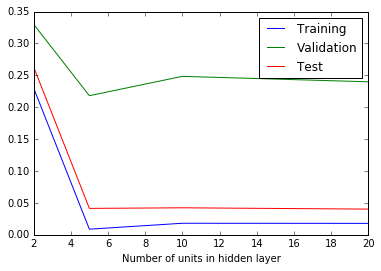

In [129]:
plt.plot([2,5,10,20],all_costs.mean(1))
plt.xlabel('Number of units in hidden layer')
plt.legend(['Training', 'Validation', 'Test'])

[(array(0.10319130438167651),
  array(0.28924590268364747),
  array(0.09287341151538964)),
 (array(0.0080827334214909),
  array(0.22411753652855818),
  array(0.041183530853513464)),
 (array(0.018188536872491976),
  array(0.24711765660062834),
  array(0.04166891419128151)),
 (array(0.020578776643949512),
  array(0.2629455494196405),
  array(0.04029627631966123))]

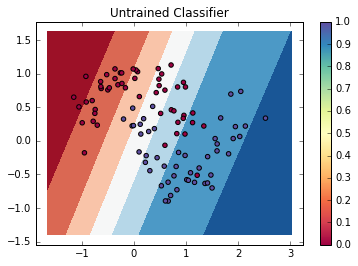

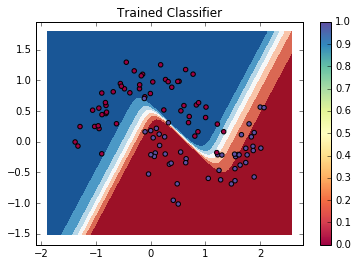

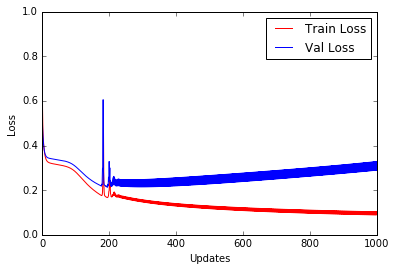

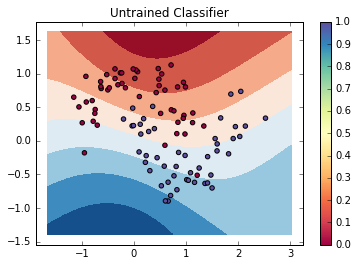

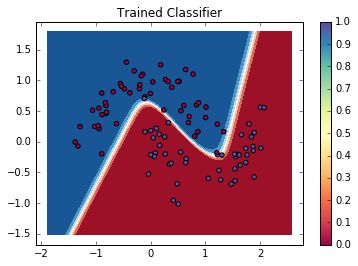

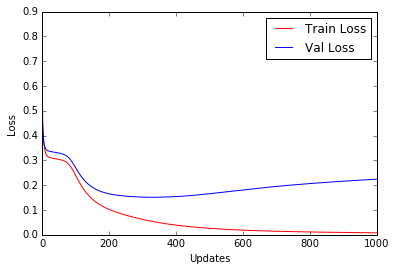

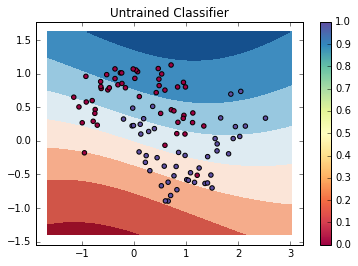

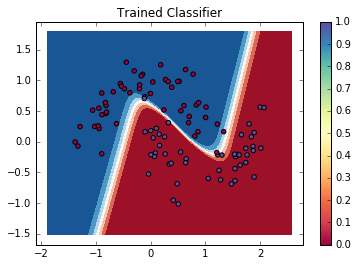

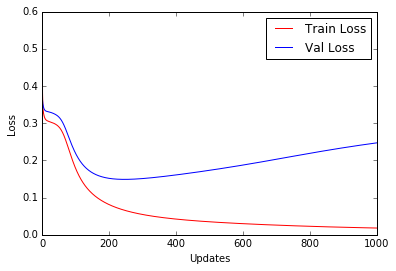

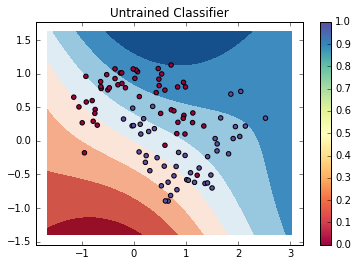

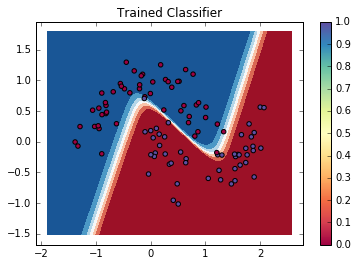

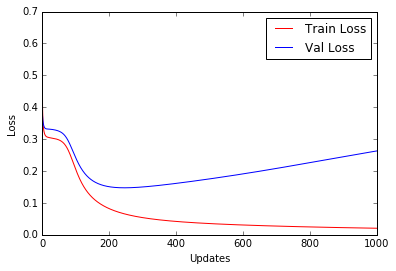

In [130]:
[train_network(num_hidden_units=i, verbose=False, draw=True) for i in [2,5,10,20]]

#### More hidden layers

In [133]:
def train_network(n_epochs = 1000, num_hidden_units = [2], verbose = True, draw = False):
    #MODEL SPECIFICATION
    l_in = InputLayer(shape=(None, num_features))
    #INSERT HIDDEN LAYER HERE
    #l = DenseLayer(incoming=l,.....
    hidden_layers = [DenseLayer(incoming=l_in, num_units=num_hidden_units[0], nonlinearity=tanh, name='hidden')]
    for num_hidden_unit in num_hidden_units[1:]:
        hidden_layers.append(DenseLayer(incoming=hidden_layers[-1], num_units=num_hidden_unit, nonlinearity=tanh, name='hidden'))
    l_out = DenseLayer(incoming=hidden_layers[-1], num_units=2, nonlinearity=softmax, name='outputlayer') 
    #We use two output units since we have two classes. The softmax function ensures that the the class probabilities sum to 1.
    # Get network output
    train_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=True)
    # Get list of all trainable parameters in the network.
    all_params = lasagne.layers.get_all_params(l_out, trainable=True)
    # print shapes of all the parameters in the network.
    if verbose:
        for p in all_params:
            print(p, p.get_value().shape)
    cost_train = T.nnet.categorical_crossentropy(train_out, sym_t).mean()
    cost_eval = T.nnet.categorical_crossentropy(eval_out, sym_t).mean()
    # Let Theano do its magic and get all the gradients we need for training. Essentially T.grad does backprop i.e. get the 
    # gradient of cost_train w.r.t. the parameters.
    all_grads = T.grad(cost_train, all_params)
    # Set the update function for parameters 
    # you might want to experiment with more advanded update schemes like rmsprob, adadelta etc.
    updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=1.0)
    f_eval = theano.function(inputs=[sym_x, sym_t],
                             outputs=[cost_eval, eval_out])
    f_train = theano.function(inputs=[sym_x, sym_t],
                              outputs=[cost_train, eval_out],
                              updates=updates)
    #now you have three functions. 
    # f_train(X,y) -> cost, y_pred which will update the parameters using backprop each time you call it, only use this on the training data!
    # f_test(X,y) -> cost, y_pred which only calculates the forward pass
    #This us just a helper function for plotting the decision boundaries between the two classes
    f_pred = theano.function(inputs=[sym_x],
                             outputs=eval_out)
    if draw:
        # Training loop
        plot_decision_boundary(lambda x: f_pred(x), X_val,y_val)
        plt.title("Untrained Classifier")
        plt.colorbar()
    train_cost, val_cost = [],[]
    for e in range(num_epochs):
        out = f_train(X_tr,y_tr)
        #out = [cost, y_pred]
        train_cost += [out[0]]
        out = f_eval(X_val,y_val)
        val_cost += [out[0]]
        if verbose:
            if e % 100 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f"%(e, train_cost[-1],val_cost[-1]))
    out = f_eval(X_te,y_te)
    test_cost = out[0]
    if verbose:
        print("\nTest Cost: %0.3f"%(test_cost))
    
    if draw:
        plot_decision_boundary(lambda x: f_pred(x), X_te, y_te)
        plt.title("Trained Classifier")
        plt.colorbar()
        epoch = np.arange(len(train_cost))
        plt.figure()
        plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
        plt.legend(['Train Loss','Val Loss'])
        plt.xlabel('Updates'), plt.ylabel('Loss')
    return (train_cost[-1],val_cost[-1],test_cost)

In [134]:
architectures = [[10,10],[10,5,5],[10,2,2,2,2,2]]

CPU times: user 2.83 s, sys: 996 ms, total: 3.83 s
Wall time: 2.63 s


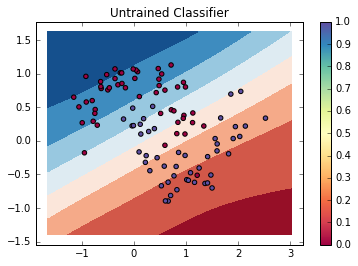

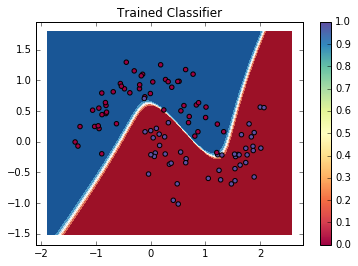

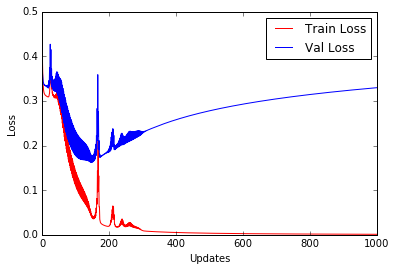

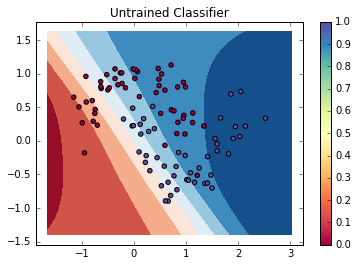

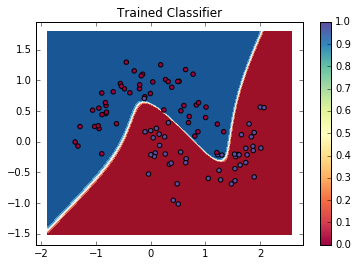

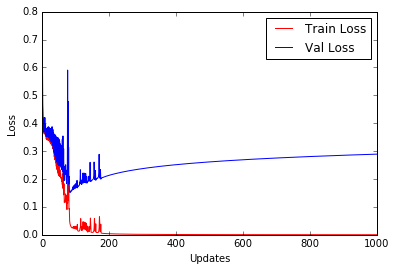

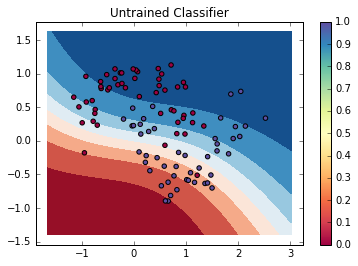

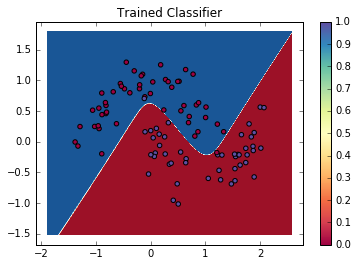

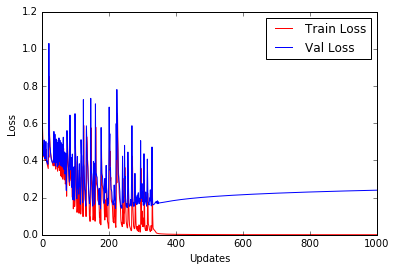

In [135]:
%%time
costs = [train_network(num_hidden_units = architecture, verbose=False,draw=True) for architecture in architectures]

  3) Overfitting: When increasing the number of hidden layers / units the neural network will fit the training data better by creating a highly nonlinear decision boundary. If the model is too complex it will often generalize poorly to new data (validation and test set). Can you observe this from the training and validation errors? 


*Yes, the training error keeps falling, while the validation error increases*


 3) We used the vanilla stocastic gradient descent algorithm for parameter updates. This is usually slow to converge and more sophisticated pseudo-second-order methods usually works better. Try changing the optimizer to [adam or adamax](http://lasagne.readthedocs.io/en/latest/modules/updates.html) (lasagne.updates.adam, lasagne.updates.adamax)

#### Adam optimizer with lrate 3*1e-3

In [140]:
def train_network(n_epochs = 5000, num_hidden_units = [2], verbose = True, draw = False):
    #MODEL SPECIFICATION
    l_in = InputLayer(shape=(None, num_features))
    #INSERT HIDDEN LAYER HERE
    #l = DenseLayer(incoming=l,.....
    hidden_layers = [DenseLayer(incoming=l_in, num_units=num_hidden_units[0], nonlinearity=tanh, name='hidden')]
    for num_hidden_unit in num_hidden_units[1:]:
        hidden_layers.append(DenseLayer(incoming=hidden_layers[-1], num_units=num_hidden_unit, nonlinearity=tanh, name='hidden'))
    l_out = DenseLayer(incoming=hidden_layers[-1], num_units=2, nonlinearity=softmax, name='outputlayer') 
    #We use two output units since we have two classes. The softmax function ensures that the the class probabilities sum to 1.
    # Get network output
    train_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, {l_in: sym_x}, deterministic=True)
    # Get list of all trainable parameters in the network.
    all_params = lasagne.layers.get_all_params(l_out, trainable=True)
    # print shapes of all the parameters in the network.
    if verbose:
        for p in all_params:
            print(p, p.get_value().shape)
    cost_train = T.nnet.categorical_crossentropy(train_out, sym_t).mean()
    cost_eval = T.nnet.categorical_crossentropy(eval_out, sym_t).mean()
    # Let Theano do its magic and get all the gradients we need for training. Essentially T.grad does backprop i.e. get the 
    # gradient of cost_train w.r.t. the parameters.
    all_grads = T.grad(cost_train, all_params)
    # Set the update function for parameters 
    # you might want to experiment with more advanded update schemes like rmsprob, adadelta etc.
    #updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=1.0)
    updates = lasagne.updates.adam(all_grads, all_params, learning_rate=3*1e-3)
    f_eval = theano.function(inputs=[sym_x, sym_t],
                             outputs=[cost_eval, eval_out])
    f_train = theano.function(inputs=[sym_x, sym_t],
                              outputs=[cost_train, eval_out],
                              updates=updates)
    #now you have three functions. 
    # f_train(X,y) -> cost, y_pred which will update the parameters using backprop each time you call it, only use this on the training data!
    # f_test(X,y) -> cost, y_pred which only calculates the forward pass
    #This us just a helper function for plotting the decision boundaries between the two classes
    f_pred = theano.function(inputs=[sym_x],
                             outputs=eval_out)
    if draw:
        # Training loop
        plot_decision_boundary(lambda x: f_pred(x), X_val,y_val)
        plt.title("Untrained Classifier")
        plt.colorbar()
    train_cost, val_cost = [],[]
    for e in range(num_epochs):
        out = f_train(X_tr,y_tr)
        #out = [cost, y_pred]
        train_cost += [out[0]]
        out = f_eval(X_val,y_val)
        val_cost += [out[0]]
        if verbose:
            if e % 100 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f"%(e, train_cost[-1],val_cost[-1]))
    out = f_eval(X_te,y_te)
    test_cost = out[0]
    if verbose:
        print("\nTest Cost: %0.3f"%(test_cost))
    
    if draw:
        plot_decision_boundary(lambda x: f_pred(x), X_te, y_te)
        plt.title("Trained Classifier")
        plt.colorbar()
        epoch = np.arange(len(train_cost))
        plt.figure()
        plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
        plt.legend(['Train Loss','Val Loss'])
        plt.xlabel('Updates'), plt.ylabel('Loss')
    return (train_cost[-1],val_cost[-1],test_cost)

CPU times: user 4.56 s, sys: 1.01 s, total: 5.57 s
Wall time: 4.38 s


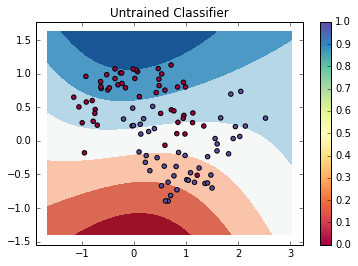

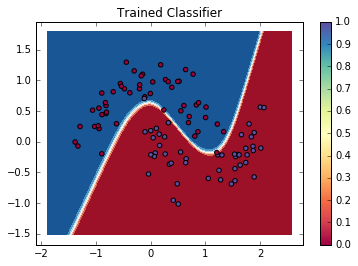

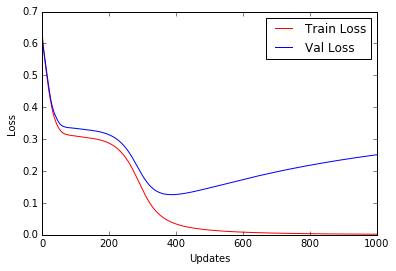

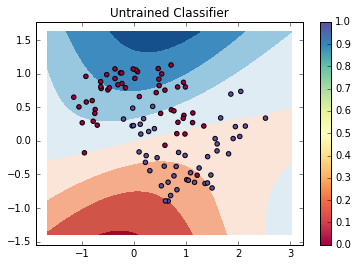

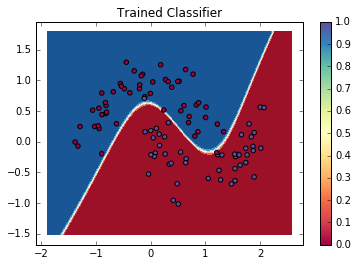

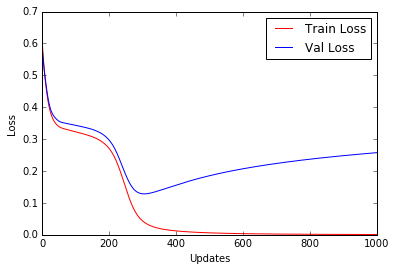

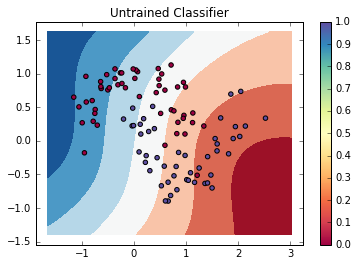

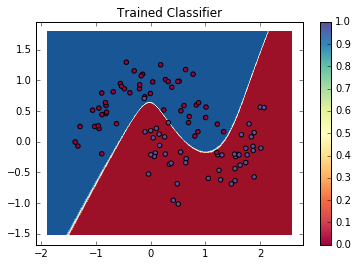

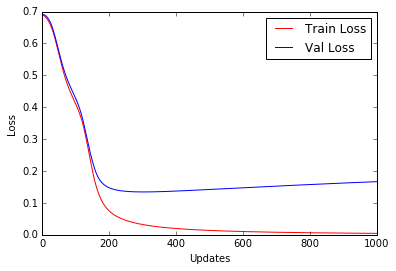

In [141]:
%%time
costs = [train_network(num_hidden_units = architecture, verbose=False,draw=True) for architecture in architectures]

# MNIST Exercise
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into 50,000 images for training, 10,000 images for validation and 10,000 images for testing. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

### Permutation invariance...
We use a feed-forward neural network to classify the 28x28 MNIST images. ``num_features`` is therefore 28x28=784, hence we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permuatation and still get the same performance. (You are of course encouraged to try this by ``numpy.random.permutation`` to get a random permutation :)). This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. Next week we'll fix this with the convolutional neural network that encodes prior knowledge about data that has either spatial or temporal structure.

### Ballpark estimates of hyperparameters
__Optimizers:__
    1. SGD + Momentum: learning rate 1.0 - 0.1 
    2. ADAM: learning rate 3*1e-4 - 1e-5
    3. RMSPROP: somewhere between SGD and ADAM

__Regularization:__
    1. Dropout. Dropout rate 0.1-0.5.
    2. L2/L1 regularization.  http://lasagne.readthedocs.io/en/latest/modules/regularization.html . We don't use this that often but 1e-4  -  1e-8.
    
    3. Batchnorm: Batchnorm also act as a regularizer
    
__Parameter initialization__
    Parameter initialization is extremely important. [Lasagne has a lot of different units](http://lasagne.readthedocs.io/en/latest/modules/init.html). Often used initializer use
    1. He
    2. Glorot
    3. Uniform or Normal with small scale. (0.1 - 0.01)
    4. Orthogonal (I find that this works very well for RNNs)

Bias is nearly always initialized to zero. 

__Number of hidden units and network structure__
   Probably as big network as possible and then apply regularization. You'll have to experiment :). One rarely goes below 512 units for feedforward networks unless you are training on CPU...
   There is some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error. 

__Nonlinearity__: [The most commonly used nonliearities are](http://lasagne.readthedocs.io/en/latest/modules/nonlinearities.html)
    
    1. ReLU
    2. Leaky ReLU.
    3. Elu
    3. Sigmoids are used if your output is binary. It is not used in the hidden layers (anymore). Limits the output between 0 and 1.
    4. Softmax is used as output if you have a classification problem. Normalizes the output to 1.


See the plot below.

__mini-batch size__
   Usually people use 16-256. Bigger is not always better. With smaller mini-batch sizes you get more updates and your model might converge faster. Also small batchsizes use less memory  -> you can use a bigger model.

Hyperparameters can be found by experience (guessing) or some search procedure. Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [SPEARMINT](https://github.com/JasperSnoek/spearmint) and many others. 

(-6, 6)

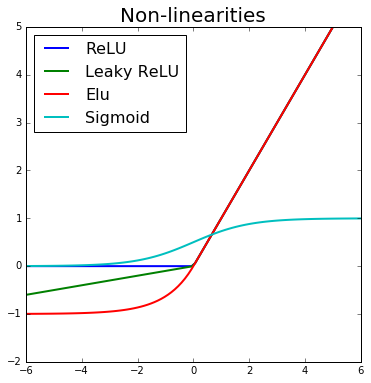

In [27]:
# PLOT OF DIFFERENT OUTPUT USNITS
x = np.linspace(-6, 6, 100)
relu = lambda x: np.maximum(0, x)
leaky_relu = lambda x: np.maximum(0, x) + 0.1*np.minimum(0, x) # probably a slow implementation....
elu = lambda x: (x > 0)*x + (1 - (x > 0))*(np.exp(x) - 1) 
sigmoid = lambda x: (1+np.exp(-x))**(-1)

plt.figure(figsize=(6,6))
plt.plot(x, relu(x), label='ReLU', lw=2)
plt.plot(x, leaky_relu(x), label='Leaky ReLU',lw=2)
plt.plot(x, elu(x), label='Elu', lw=2)
plt.plot(x, sigmoid(x), label='Sigmoid',lw=2)
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [145]:
#To speed up training we'll only work on a subset of the data
data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train'][:1000].astype('float32')
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
targets_test = data['y_test'][:500].astype('int32')

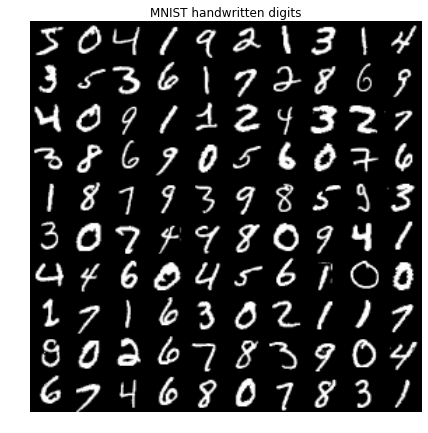

In [146]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [147]:
#define the model
num_class = 10
num_features = x_train.shape[1]

l_in = InputLayer(shape=(None,num_features))
l_hid = DenseLayer(incoming=l_in, num_units=500, nonlinearity=elu)
l_out = DenseLayer(incoming=l_hid, num_units=num_class, nonlinearity=softmax)

In [148]:
sym_x = T.matrix('sym_x') # a symbolic variable taking on the value of a input batch.
sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

# Get network output
train_out = lasagne.layers.get_output(l_out, sym_x, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, sym_x, deterministic=True)


# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean()
# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)


# Set the update function for parameters 
# you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=0.1)


f_eval = theano.function([sym_x],
                     eval_out, on_unused_input='warn')

f_train = theano.function([sym_x, sym_t],
                          [cost],
                          updates=updates, on_unused_input='warn')

In [149]:
#Test the forward pass
x = np.random.normal(0,1, (45, 28*28)).astype('float32') #dummy data

model = lasagne.layers.get_output(l_out, sym_x)
out = model.eval({sym_x:x}) #this could also include mask etc if used
print("l_out dim(%i, %i)." % out.shape)

l_out dim(45, 10).


# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural networks you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The parameters are updated after each mini batch.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``f_train`` is called.

In [ ]:
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 500
learning_rate = 0.1
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
for epoch in range(num_epochs):
    #Forward->Backprob->Update params
    cur_loss = 0
    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train[idx]
        target_batch = targets_train[idx]    
        batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
        cur_loss += batch_loss[0]
    loss += [cur_loss/batch_size]
    
    confusion_valid = ConfusionMatrix(num_classes)
    confusion_train = ConfusionMatrix(num_classes)

    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train[idx]
        targets_batch = targets_train[idx]
        net_out = f_eval(x_batch)   
        preds = np.argmax(net_out, axis=-1) 
        confusion_train.batch_add(targets_batch, preds)

    confusion_valid = ConfusionMatrix(num_classes)
    for i in range(num_batches_valid):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_valid[idx]
        targets_batch = targets_valid[idx]
        net_out = f_eval(x_batch)   
        preds = np.argmax(net_out, axis=-1) 
        
        confusion_valid.batch_add(targets_batch, preds)
    
    train_acc_cur = confusion_train.accuracy()
    valid_acc_cur = confusion_valid.accuracy()

    train_acc += [train_acc_cur]
    valid_acc += [valid_acc_cur]
    print("Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
    % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur))

Epoch 1 : Train Loss 1.168721e-03 , Train acc 1.000000,  Valid acc 0.822000 
Epoch 2 : Train Loss 1.160387e-03 , Train acc 1.000000,  Valid acc 0.822000 
Epoch 3 : Train Loss 1.152158e-03 , Train acc 1.000000,  Valid acc 0.822000 
Epoch 4 : Train Loss 1.144032e-03 , Train acc 1.000000,  Valid acc 0.822000 
Epoch 5 : Train Loss 1.136007e-03 , Train acc 1.000000,  Valid acc 0.822000 
Epoch 6 : Train Loss 1.128082e-03 , Train acc 1.000000,  Valid acc 0.822000 
Epoch 7 : Train Loss 1.120254e-03 , Train acc 1.000000,  Valid acc 0.824000 
Epoch 8 : Train Loss 1.112522e-03 , Train acc 1.000000,  Valid acc 0.824000 
Epoch 9 : Train Loss 1.104885e-03 , Train acc 1.000000,  Valid acc 0.824000 
Epoch 10 : Train Loss 1.097340e-03 , Train acc 1.000000,  Valid acc 0.824000 
Epoch 11 : Train Loss 1.089887e-03 , Train acc 1.000000,  Valid acc 0.824000 
Epoch 12 : Train Loss 1.082523e-03 , Train acc 1.000000,  Valid acc 0.824000 
Epoch 13 : Train Loss 1.075247e-03 , Train acc 1.000000,  Valid acc 0.824

In [1]:
epoch = np.arange(len(train_acc))
plt.figure(figsize=(12,6))
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Updates'), plt.ylabel('Acc')

NameError: name 'np' is not defined

# More questions (NOTE that before retraining, the network must be reinitialized.)

1. Do you see overfitting? Google overfitting if you don't know how to spot it.

*The validation accuracy starts falling after ~70 epochs, while the training accuracy keeps increasing, so the network is overfitting.*


2. Regularization is a method to reduce overfitting. Adding noise to your network is a popular method to fight overfitting. Try using Dropout in your network. [Lasagne DropoutLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html#lasagne.layers.DropoutLayer).

In [37]:
from lasagne.layers import DropoutLayer

In [155]:
def train_mnist_net():
    #define the model
    num_class = 10
    num_features = x_train.shape[1]

    l_in = InputLayer(shape=(None,num_features))
    l_hid = DenseLayer(incoming=l_in, num_units=500, nonlinearity=elu)
    l_dropout = DropoutLayer(incoming=l_hid,p=0.5)
    l_out = DenseLayer(incoming=l_dropout, num_units=num_class, nonlinearity=softmax)
    
    sym_x = T.matrix('sym_x') # a symbolic variable taking on the value of a input batch.
    sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

    # Get network output
    train_out = lasagne.layers.get_output(l_out, sym_x, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, sym_x, deterministic=True)


    # Get list of all trainable parameters in the network.
    all_params = lasagne.layers.get_all_params(l_out, trainable=True)

    cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean()
    # Let Theano do its magic and get all the gradients we need for training
    all_grads = T.grad(cost, all_params)


    # Set the update function for parameters 
    # you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
    updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=0.1)


    f_eval = theano.function([sym_x],
                         eval_out, on_unused_input='warn')

    f_train = theano.function([sym_x, sym_t],
                              [cost],
                              updates=updates, on_unused_input='warn')
    
    batch_size = 100
    num_epochs = 500
    learning_rate = 0.1
    num_samples_train = x_train.shape[0]
    num_batches_train = num_samples_train // batch_size
    num_samples_valid = x_valid.shape[0]
    num_batches_valid = num_samples_valid // batch_size

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    test_acc, test_loss = [], []
    cur_loss = 0
    loss = []
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]    
            batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
            cur_loss += batch_loss[0]
        loss += [cur_loss/batch_size]

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print("Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur))
    return train_acc, valid_acc

In [156]:
train_acc, valid_acc = train_mnist_net()

Epoch 1 : Train Loss 1.750365e-01 , Train acc 0.738000,  Valid acc 0.690000 
Epoch 2 : Train Loss 1.010471e-01 , Train acc 0.824000,  Valid acc 0.784000 
Epoch 3 : Train Loss 7.618466e-02 , Train acc 0.854000,  Valid acc 0.792000 
Epoch 4 : Train Loss 6.582957e-02 , Train acc 0.877000,  Valid acc 0.816000 
Epoch 5 : Train Loss 5.639402e-02 , Train acc 0.889000,  Valid acc 0.818000 
Epoch 6 : Train Loss 5.099991e-02 , Train acc 0.895000,  Valid acc 0.828000 
Epoch 7 : Train Loss 4.811339e-02 , Train acc 0.902000,  Valid acc 0.836000 
Epoch 8 : Train Loss 4.506919e-02 , Train acc 0.907000,  Valid acc 0.838000 
Epoch 9 : Train Loss 4.000235e-02 , Train acc 0.913000,  Valid acc 0.836000 
Epoch 10 : Train Loss 3.978971e-02 , Train acc 0.922000,  Valid acc 0.838000 
Epoch 11 : Train Loss 3.716885e-02 , Train acc 0.924000,  Valid acc 0.844000 
Epoch 12 : Train Loss 3.509895e-02 , Train acc 0.926000,  Valid acc 0.842000 
Epoch 13 : Train Loss 3.350385e-02 , Train acc 0.933000,  Valid acc 0.846

(<matplotlib.text.Text at 0x7f4327640a58>,
 <matplotlib.text.Text at 0x7f43276ba588>)

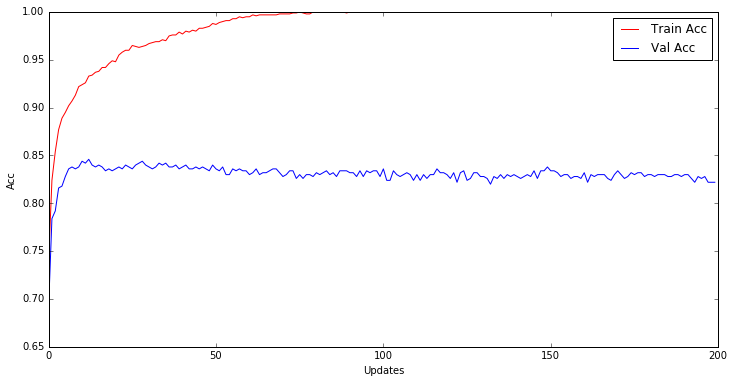

In [157]:
epoch = np.arange(len(train_acc))
plt.figure(figsize=(12,6))
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Updates'), plt.ylabel('Acc')

*Now the validation error doesn't really fall, it just flatlines, although it's hard to see for the noise*

### Exercises from the book

#### 1)

Verify that  σ′(z)=σ(z)(1−σ(z))

In [142]:
from sympy import * # yes, I am that lazy ;)

In [93]:
z = symbols('z')
sigma = 1/(1+exp(-z))
diff(sigma,z).simplify()

exp(z)/(exp(z) + 1)**2

In [92]:
(sigma*(1-sigma)).simplify()

exp(z)/(exp(z) + 1)**2

#### 2)

One gotcha with the cross-entropy is that it can be difficult at first to remember the respective roles of the ys and the as. It's easy to get confused about whether the right form is $$−[y \ln a+(1−y)ln(1−a)]−[yln⁡a+(1−y)ln⁡(1−a)]$$ or $$−[alny+(1−a)ln(1−y)]−[aln⁡y+(1−a)ln⁡(1−y)]$$. 
What happens to the second of these expressions when y=0 or 1? 

*We take the logarithm of 0 in either case, and there is no real x such that e^x = 0*

Does this problem afflict the first expression? Why or why not?

*No, because in the first expression, there is no ln(y) or ln(1-y)*

#### 3) - 5)

Not done